Poonam Ligade
7th Feb 2018
---------------------------------------------------------------------------------

1. [About Yelp](#overview)
2. [NLP using Keras Pretrained Glove word Embeddings](#keras)

    2.1.  [Preparing text data](#preparation) 
    
    2.2.  [Converting text into numerical representation i.e Tensors](#numerical)
    
    2.2.  [Split train and validation data](#split)

3. [SpaCy Capabilities Demo](#spacy)

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
import pandas as pd
import numpy as np
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

import spacy;

/home/ashish/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


<a id='overview'></a>

## About Yelp

**Yelp connects people with great local businesses.**

 ![yelp](https://s3-media3.fl.yelpcdn.com/assets/srv0/seo_metadata/f9149736ad8d/assets/img/logos/yelp_og_image.png)

This dataset is a subset of Yelp's businesses, reviews, and user data.

In this kernel I'm trying to do Natural Language Processing & Sentiment Analysis

What's in a review? Is it positive or negative? Yelp's reviews contain a lot of metadata that can be mined and used to infer meaning, business attributes, and sentiment.

Credits due :
1. [Jeremy](https://www.kaggle.com/jhoward) [Kernel](https://www.kaggle.com/jhoward/improved-lstm-baseline-glove-dropout)
2. [Keras](https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html) Blogpost

<a id='keras'></a>

## Bidirectional LSTM using Keras
How to use pre-trained word embeddings in a Keras model.

Bidirectional LSTMs are an extension of traditional LSTMs that can improve model performance on sequence classification problems.

In problems where all timesteps of the input sequence are available, Bidirectional LSTMs train two instead of one LSTMs on the input sequence. The first on the input sequence as-is and the second on a reversed copy of the input sequence. This can provide additional context to the network and result in faster and even fuller learning on the problem.

In this tutorial, you will discover how to develop Bidirectional LSTMs for sequence classification in Python with the Keras deep learning library.

credits : Jason Brownlee [Blog](https://machinelearningmastery.com/develop-bidirectional-lstm-sequence-classification-python-keras/)

In [2]:
yelp_reviews=pd.read_csv("yelp_review.csv",usecols=["stars","text"])
yelp_reviews.head(2)

,stars,text
0,5,Super simple place but amazing nonetheless. It...
1,5,Small unassuming place that changes their menu...


In [3]:
#let's check out a sample review
yelp_reviews.text[5]

"Cycle Pub Las Vegas was a blast! Got a groupon and rented the bike for 11 of us for an afternoon tour. Each bar was more fun than the last. Downtown Las Vegas has changed so much and for the better. We had a wide age range in this group from early 20's to mid 50's and everyone had so much fun! Our driver Tony was knowledgable , friendly and just plain fun! Would recommend this to anyone looking to do something different away from the strip. You won't be disappointed!"

In [4]:
##checking for nulls
yelp_reviews.isnull().any()

stars    False
text     False
dtype: bool

Great we dont have enemies!
<a id='preparation'></a>

### Preparing Text Data

In [5]:
yelp_reviews.stars.unique()

array([5, 4, 3, 1, 2])

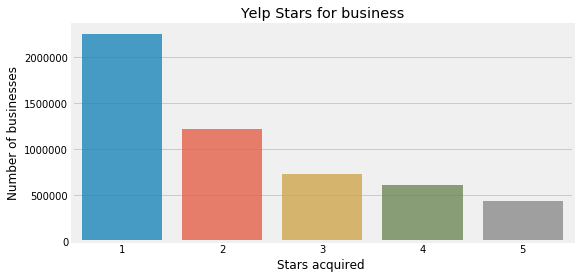

In [6]:
x=yelp_reviews['stars'].value_counts()
y=x.sort_index()
#plot
plt.figure(figsize=(8,4))
ax= sns.barplot(y.index, x.values, alpha=0.8)
plt.title("Yelp Stars for business")
plt.ylabel('Number of businesses', fontsize=12)
plt.xlabel('Stars acquired ', fontsize=12);

Since I wanted to make it simple binary classifcation problem with positive i.e, high polarity(stars= 4 and 5) and negative(stars= 1 and 2) labels I have converted stars column as binary column. We can keep neutral class as stars =3 but right now i am not dealing with that for sake of simplicity.

In [7]:
reviews=yelp_reviews[:300000]
reviews=reviews[reviews.stars!=3]

reviews["labels"]= reviews["stars"].apply(lambda x: 1 if x > 3  else 0)
reviews=reviews.drop("stars",axis=1)

reviews.head()


,text,labels
0,Super simple place but amazing nonetheless. It...,1
1,Small unassuming place that changes their menu...,1
2,Lester's is located in a beautiful neighborhoo...,1
3,Love coming here. Yes the place always needs t...,1
4,Had their chocolate almond croissant and it wa...,1


In [8]:
texts = reviews["text"].values
labels = reviews["labels"].values

In [9]:
alice_shelley=b'iVBORw0KGgoAAAANSUhEUgAAA4QAAAOECAAAAADcJaDnAAAccklEQVR4nO3d2XbbSLJAUfCu/v9f5n2wVZbECVNmRCD2fuiy3TWAQB5GgqSk230BIv1f9AFAdyKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCK8hFv0AXCACCGYCK/AICztf9EHwGESLM4khGAiLM8grM52tJQ/wd0f/uT333Z/9qcV/H04ZY9/F5OwoE+z77bcbuZjHXWfMxv6F9b995/cH/+uilf22eO5PhGW8Wu23X/8wUOVP/40t9uzo69x6OewHa3q54bz+e6zyp709uMvD7++OhEW8ekm73Z79jdVWMq3pcZxjuPV0ct4/jppkX3d7d64RJOwhv0LNPvS/m8rmv1AxzEJK+iwPjs8xhdMwsvLvbpfHl3uwz6VCK+v5nKucS97ChEWcLSimhX24Z4wm4c3rCV0dSZhMl3fsO5MhLn87O52+/gm/Y5/K8nYjmbyGIt8GjAJW9ByZiKEYCJMZOC8MgoTE2EeQmlKhGlosCsRQjARQjARptHoE8v8IMI8hlbojjMvESZiFvYkwkxGVmgUpiXCVNpVmPKgZhNhLnakDfkqCuKYg8uymISdpFvy6Q4oiAiTud/77Ej7PNL3RNhIqZ+XVulYDxJhPgMHRKOVXYgIE2qzI23zQN/z8wmTGjazkl3wN48z2ZGOYxImNWwF1tmR1jnSg0SYVZM50ORhviXCtEYtz2QDRoUibChZhYiQYEahCNMaN7CqjMIqx3mUCLMauQKrfHSmyGEeJUKivXnLvkeFIkyqx/JjWUSY1PD9Yq7Gm782I0Iyy/VkMYgIM5qw9HKt7jd3hbkOdAgR5jNn3TVY3FWIkAxa3xWKMJ2eI6rz2xS+21oy119y/GYSQjARkkPjb3UhwrZsfLMQYS6dy2g7CkWYSucG+xJhJhpsSYR9ST4JEZJG15tCESYyezSlG4VNKxQhyV2/TBGm0eGLdj65fnDPiBCCiRCCiTALm9FlabofFWEObgj/6lihCMmtQZUiJLUGDYoQookQgomQzDrsRkVILh1fJRYhmXRsUIQ5xKy9Fnu9AkRIIi0HoQhTMAhfKHCIJ/AduBPo+fz/6OE89GjQJCSNts9FIiSJxwabDEIRkkTbOeieMIGo1ZdrzjRu0CQM13n1/dP6LIiQBFo3aDsaq/fi+/LiLOTaLw9kEnaVfomnP8DTiDBS4CBMtMSfn4VEBzia7Wgce9FlWZwGEQay+JbFWVgW29E4sasv/WYv/QGeyCSMYQAsy/LmNHRq0CRsKseTgAaXZTEJY+RIgCREGCBDg7f4aZPhNKQgwvksvmVZ3p2G8KeHydwTTpelwSzH8aBbgybhbImW/i1wtSc6DfFMwrksvo/aDUIRdhb3jPDmv9yvQdvRqczBZVmcht9Mwoksvs8aDkKT8DT/FXb/87vH1aRBnop8hewaKqcVcfHfn6+Wy9F29KDKDebTskHb0WMkuNXbM9azQRHupL5dnLZnbEd3sZg4j0m4gwR38qLMUyLcRH4HOHkv2I5uYRkN1HYQmoTrKfAY5+8VEa5g+RznHL4mwo8snxN8PIl9N6Mi/EiCJ3AS3xLha5bOOdacx86D0Kujr2nwHM7jJybhC5YOs4jwCQGex7n8TIQPLJsTrTuZre8I3RM+0uB0zRs0CX8Q4Mmc0DVMwm8smZM5oauYhP+xYs628ox2342K8A8Bvrb75zc5qSvZjja2Kq7b3prWzsH2g1CEy7J4zn7j9t//7PkHWcN2tO9i+TyC/js3W789bd+Tukf7SWi5vDbj3NiMmoS8tD/BDf+kBpfuEbYeg2/X/+8zs3Y/2vqM7tV+O8oze1va+s8ZhMvSfBJ62n5iyi6U7xpHaM08en1O3u9Hd55Lg3BZls7bUQ1u8+Z83TR4SNdJKMEnBew6Kc7kYU0jtHKONnjCGTQI/+q7HeWX2Q3ypeUktIKeTKGPJ+XfSzPO37k6RmgNPVpzTk4+b3ajXxpuRzWYggb/028SanB5KCDgnGjwn24RSnBZfhXglERrth214JbFFMqm2yTkl6CnJc8D37SK0BxcluV7AGEnRIPfddqOavCP28MvZtPgD40i1OCX24+/EG3rd/Apy4rLo8uaW6vLPaEG05Dgb022oxokrxaTUIKJGIQP2twTSjGFPsttg0YRLjoM1mqtbdDknpAENPhCr0m4LItxGKDfItukYYQqnKvhCtuo43bUqpjJ2f6oxVsUxNDfOiJkEAmu1XE76p6QVExCzmcIbtIwQoNwMAlu1C1CBQ6nwa2aRajBsQS4R68INTiUBPdpFKECB9PgTo0iZCABHiBCjpPgIY3erL9bKqTU76so3Bqeqd3yGaFfhIsOz9Jx7YzQaDv6j8VzCqfxJC0n4bIsxuExbZfNCC0n4bIsltERXuM6Vd8IVbibM3euvtvRZVnsSbfrvV7GaB6hDDfpvlgGabwdZSsNjtF+Ei6G4UpWyigmodVFMBEuKlzFSRpGhMtiga3gFI0jQtbQ4EAiXJbFR0CIJMK/VEgUEbKCp6iRRMhnGhxKhF/cFr7kzIwlwn+sNUKIEIKJ8Buj8Bn79NFE+J3lRgAR/qDCB07JcCLkLQ2OJ8KfrLmfnI8JRPiLVfedszGDCH+z7pjMT2XiJc9Hc5iEEEyED7w5/ZfzMIkIeUGDs4jwCctvcRImEiFPaXAe3/z3uebfENiqmMkkhGAifK73KOj96KcT4QvWIbOI8JXGFTZ+6CFE+FLbpdj2gUcRIb9ocDYRvmY1MoUI3/ApUmYQIQQTIT+Z/tOJ8C0bUsYT4QcqZDQRQjDfY+aTe/svqWAwk3AFW1JGEuEaKmQgEa6iQsYR4TptKmzzQBMR4UoWJ6OIcC0VMogIIZgIVzMKGUOE63X4IGmDh5iPCLfokCHTiXAbFXI6EW5kGHI2EW6mQs4lQgjmS5m2uy++uokTmYT72JNyGhHudM0Kr/mosrMd3evPerUt5TCT8JhrvWNxqQdThwiPsnA5yHb0sL8V2piyk0l4FhORnUR4mvoV1n8ENYkQgonwNG4K2UeEZ9EgO4nwJBpkLxFCMO8TnsEY5ACTEIKZhCf4bxDen/0hvHfzBu1RTxP88X8UYSkEEeFYhUK0EqLYjo5131ihr1JsyAszx3zMpcx8KXOg1yPCY05euvch/1ZyE2Em94df0IAIE7k//SVXJ8LBNrzGcn/5Gy5NhGnIrisRZhHcoKeAOCJM4iGCud9MUYOBvFk/1spbwugGov/7vZmEQx366IsymhDhSGsblFtrIoRgIkzg1SCcNiBN4lBemAn3poD7nK+n0GAsk3CgVQXFFxB/BM2ZhMOsG2IKwCSM9anBa/38Q57y7S0GOW8ODr4ttADC2Y4OsDobAbDYjo5QqsEMx9CdSXg236SJjUR4LgmymQhPtaXBDBvBDMeAe8IoGdZ/hmPAJDyTvSh7mITnKdegQZiDSXiaTQ1mWP8ZjoFFhKcZNgbLzVe2sh0NkWEIZTgGlsUkPIk5yH4m4RkqpmIQpmESnmBrgxnWf4Zj4A+T8LiBDQ4bsRpMRISHDdyLVtzmspkIE9NgDyI8anMpGXaCGY6BL16YOWb7sFq//g3CJkzCycwgfhPhISOH1cB/t2eCVGxHDxi6X7QZbcMknMsM4oEI99sxq5I0aMqmYju6156FnOGzMqRjErYk8UxEuFPxZVz88K/FdnSX0Wt4fCO3LPeniHAiq56nbEf32DWosjVoR5qFSbjdVVavHWkSJuEsFjwviHASDfKKCDe7ym50udRDqUyEW+1buNsG4bQ4VJiBCDe62LK92MOpSYTbTFm0M8tQYTwRznDftBud24UKw4lwi9uMG8LZVBhNhOmIohufmNlgyhzUYDsm4XpXbVD2wUS42uVeGP33H5VhKNvRsfLPQcKZhGvN+PIlDbYkwnX27djKNKj+SCIcZ9tb9LElqDCQCIfZ+hZ9bAcqjCPCVep+n1/yE+EYW7ei8aMo+r/f2M0T9mcjfwjh7v/E+SyFICbhCCUbzHEQHXmz/rONi9NAYRuT8KPxDWb52FiSw2hHhJ9MaHD7PzJIlmeDZmxHT7VnK2rhdyfCD7YksutuUIPt2Y6+NX5/lqzBZIfTg0l4kp2viaZb9N44ns8kPMX2D8j8ka7BlId0dSJ8p/7PAt0h5UFdmu3ocTZwHOIW4I1VM2H/Ccw7ciyKqWxHXxscSd4GMx/aFdmOHmJkcJxJeMSBBnN/Qiz1wV2OCF8auhCzr/Lsx3cptqOvfFyG196KesVuHhG+0HoOMpXt6F5H7gfPO4pxct+0XopJuI/NGqcxCZ97Pwb2flR0zb87jyrHWZ5J+IwbwmVZluVm4E9hEu7QYg4yjUm4mQQ5l0n4aODrgtUarHa8NYlwK7dJnMwHIx68ffbvtxe1QIZzT/jbqFJKFsgMtqObNBwLnjyGMwl/+vAm/ah/MZ2ZhBsc+E4WhRssfOhFiPCHcS/KFKbCwWxHv3u33GxFGcQk/GZMg5W3on+UfwDJiXCdK35jw/Wu8BgSE+E/b5Za7wav8iiyck/4Zche1OLlMxH+ZQwSxXZ0WZb3L550fWfiB08nA5mEyzJoiV1r3foq+3FEuAx7exBWsR0d9vbg7n+SZtpOwr4/cmkvX3o6StdJuC6SY9/a8Gou+MSSQ8+nt5XLyduDv7RcLOP12o5ui0ODTNEpwo1taJA52mxHN5ehwSe6rJa5rj8JZzdx5Qa9ZT/E1SPcmYS3B5nnOhHmWP05joJS6keYatmnOpgh2ryIMFH9CM9nmTFV8QiTTZ5khzOEUXi60qd0zJr33sQHlZdMSpUn4ZBFb4UxW+EPcGdrsMsg7PNAZ6m6HR20ELw/uErRRZNV0UmYrkHYrWaEg16RsRddqdejHa5khMleFb3Cd7q/uNzXp+Sro99yOe3s2oluUfWlhJxKTsJvzloMFhVh6j+lnTMLj5yG3HudUSotnNuS+nhLbke/O17A0avTs8FyEo+b6tvR+AbJL/k1Lh5hgimU4BBClHvceQ+49nb08Hk9/hSZ99LyS9oNaelJeDSAE763b+MG6z30rEec9tnhs/gxmPWizlJn7XxdqZxHXHc7eqyAnFeDlspuRw81eMrPmPBZtTq+rnfOS1Z0O3oswfAjuIqki+fbtbn//rOMh1xzO7ryZyqFHwEh7sWuTs1J+PkkD35Yxa7yMFlXz+MsvP36fSYl7wmDE7i5G/xS4ETcvv3vz1+lUTLCT+5+uGdz36//7+ryVVjxnvDTWbQV5bv0F6xghKENpr+gfJTudZB0B7TK6xRMwcnyrp+wRbJZzXvCl2dRg7NVPCXZXlmrOQlfXXvvDAZIu4Li301eqWqEj2fYEAySeAWtumjxx1/whZk/fn4qYvSJlGBJRT46U/OecFn+dXdfRr8gmu0WIpnMJyd+yq1Rdjs6TeY1lkOBJfTuIsYfft1JOIch+FmBU5T7I1Qm4WsFFlcSBRbRm4sZfvQm4UsavJLXpYU3KMJX7EM3cK4OsR19wpraLv86enVV44/cJHykQaYS4QMNXlP8xHul7CdmxhAg85mEEEyE33hFdL/8p+7FESbYpXp19I/8ayi95CtpRYO3oAdhEi7LosEzlDyH97e/ncQLM8tSdP1wrrhF0D5C/fXw8ToHLgTbUVhin4ybT0JzsIlPFzp0ITSOUIAny/tKe+a96GI7yomyPq0lb7BvhN6YHyDnOX13VLdPf8MMPbej0WedaVLfDP7VchJmOPHwpd8kVGAnJa523le0RihxSUpLtZw2X+6go281CTXIG2FPIG0iFOAUiXZWda54gwjrXIwrSFNhoct+/QgLXQzOs/WyRz53XD1CCfZUqcGLv0/oYzHzpTjlpRq8eIQESFHhJtE/LibNffQA9VbDRYSvqU1XPvxoL3tPKMDGql38i25Hq10GOrvkJJQgq8XvRq93TyjABCYtqn/X+v78j1fIsP6vth3VYAZzrsKL/8q2/3iGBXOtCL0vmMSM63BKgykqvMw9YYJzyUw/LviRu6qob37/z1UmoQZ7K339LxJh6WvACSqvgPrb0cpn/7rmv+r+979YcTmUn4QVT3oHQdel5HIo/j5hyXPexOCVdeKlj26g7HZUfr1d6fqXjZDe7j8rPHJDGD0Ii0Z4padBTnD/+suOlRHeYMUXZm4+F1PCxKt0f/KrQgpGCMuP8EqW9025V0dNwUJmvEB6f/JnWyQIoNQ9oQD57r7cDjeUoMFS21EN8svjTnRjVBkaLDQJJchF1YhQgDWlf8Uhx/GV2I5qkCFyNJj/uUqBpQUsr/ULJsvaTxyh+q4gc4VZ1n6Ne0JYr9wXFqa9J/TZNA7JMuZWSBqhBK8i7kLWqTBphHDYx8+UZnmmFyHXVWQY5owwy1MUx4VeyxpfYJHzLQoRXkmGJfZ0RWU4sGVJOgk1yMme9ZalwZwRwnhpGrQdZah7/E96+OvPmspxLL+IkFHSLa2ciz3rdjTpyWKLfBcx3xH9kTNC6su64hNKGqErWJ0ruF7SCKEPEUIwEUIwETKEd5nWyxphjU/ewgmyRkh1RuFqeSM0Cmkib4TQhAghmAghWOII3RTSQ+IIVVibl0fXyhwhtalwpdQRGoW1qXCd1BFCByKEYLkj9AlSGsgdodtCGsgeIVyeCBnHy6OrpI/QbSFXlz5CKjMK1ygQoVFYmApXKBAhXJsIIZgIGcp+9DMRQrAKEXplprKbWfhJhQhVyKWViFCFXFmNCKnMfvQDEUIwETKcUfhekQjdFJamwreKRKhCrqtKhCoszSh8p0yElKbCN+pE6Kt7S1Pha3UitCPloipFCJdUKkKjsDD70ZdKRahCrqhWhCoszCh8pViEKixMhS9Ui9A7FVxOuQipyyh8rmCERiHXUjBCFXItFSNUYVW+6dNT/4s+gMn+9msxkEfJSbjf/ddfIV7NCPc2pL1otiBP3Kquyx1X8+dDtRxCVF1vI9WchCs8vKn/+w+shhBem3l01QjvKqOKsq+O3l9vKP+9+nL7/UeQT9l7wmV5VeH919/y+hHaGYWovOSGKL0dfXo1f9/6vbnkVkMIz32/lN2OLsvyY8P557dP/g5IrvQkXH4Ouu3BSTSEUfhT9QihvNIvzHy5LfuHmmflAFdYdCeqfU/4l2tKZbajEKx9hL5nDdHaR2gzSzQRQjAR2pESTIQQTITL4raQUCJclkWFRBLhHyqcyMn+SYR/WRhEESGzeb77RYRfvFExifP8mwghmAj/8RRNCBF+o0IiiPA7FRJAhD+ocDSvfz0S4U/WyFhO7xMihGAi/M1z9Tj2GU+J8IGVwlwiZBrPbs+J8AmLZQin9QURPmO5DOCkviLCpywY5hHhcyo8mzP6kghfsGZO5SXnN0T4ilXDJJf4qUyD+IFNJ7HG3jMJX7OFOofT+IEIGUyDn9iOvmVHepDltYIIP5DhARbXKrajH1hHjGYSfmQW7mJhrSbCFWS4mWW1ge0oBDMJVzELn7kvy9NTY01tYxKuYlk98eekPH6kwcnaSITrWFgP7g+/ePpbPvpf9AFUcbcl/eF5agLcQ4Sr3VX4HwmeyXZ0PWvsy/MNqPOzk1dHNzEMpXY+k3ATX93U/gQMIEK20OAAtqPbdd2TWiqDmISspMFRRLhdz9XY81FPYTu6S7cdqVUykkm4S69F6TXhsUS4j2XJaWxHd2uyJbVAhjMJd+uxOns8ylgi3K/D+uzwGMPZjh5z6T2ptTGHScgrGpxEhMd49Z7DbEdPcMU9qXUxjwjPcLUKLYqpbEchmEl4lstMQytiNhGe5xIZWg/z2Y6e5wrr9wqPoRyT8GSFx6GlEMQkPFnZlewdzzAiPJvFzEa2o4NU2pZaA7FEOEyVDK2AaLajwxRZ3EUO88pMwuHSTkSXPgkRzpCxQxc+DRHOkS1Dlz0REU4WXaPrnY8IZwus0LXOyaujs8WVoMGk/LjsDuSXmgivT4LJ2Y5engazMwmvTH8lmISzTXx1VIM1iBCCiXAyg5DfRDiXBnkgQggmQggmwquyGy1DhBBMhBBMhFNFfzUhGYkQgokQgolwJrtRnhAhBBPhRAYhz4gQgokQgokQgokQgonwonx+uw4RQjARzuMdCp4S4TXZjRYiQggmQggmQggmwktyS1iJCCGYCCGYCKfxNiHPiRCCiRCCiXAWu1FeEGER3nS4LhHWcFfhdYmwgvt9MQuvS4QFyO/aRJjf/ddfuRgRpqe9qxNhdhq8PBEmd3/xa65DhLnprgERpnZ/+1uuQYQQTISZmXwtiDAxDfYgwrw02IQI03rW4F2YFyRCCCbCSc76ml6j8Hr+F30APCe2PkxCCCbCnF4PQiPyckRYzooKhVqKCOfY9rrM+3ciJHYxIrwgldYiwoRE1IsIpzj3O/+K9FpEmM/nxlR4Kd6sz0Zg7ZiEEEyEEEyEyZywG7WhLUaEuQioIRGmosGORAjBRJiJQdiSCGdY+YEZDfYkwjw02JQIJzj3k6Mj/oVEEuF4GuQtEaZhN9qVCLPQYFsiTEKDfYkQgvl6whTMwc5MwuG8lsl7IszAIGxNhKOtGIQa7E2Eg2mQT0QYToPdiRCCiRCCeZ8wmM0oJuFY3iTkIxEO9bFBgxARDmUOsoIIIZgIC7KHvRYRhtqZkwovRYQDjXtZRoVXIsJxgl6WEWg1Igx0IJfX/6gGyxHhMGMHodauQ4RVqfAyRHgx2qzHB7hHGf6JtbsP5FyECMfQB6uJMMo5P5xe7BfgnrC2Xynf3RIWJMIh5g2o+8vfUIXt6AgzN4nCK88kHGBNg9rhiwjPp0E2EeHpvGDJNiI826oGDUL+EeHJzEG2EiEE8xbFqcxBthPhKcTHfrajZ9AgB5iEhymQY0R4iAA5znYUgpmEB5iDnEGEeymQk9iORvCpNb4RYQAN8p3t6D42o5zGJNxFg5xHhBBMhPO5JeQHEUIwEe7hlpATiRCCiRCCiRCCiXA6L47ykwhn0yC/iHAyDfKbCCGYCPcwzjiRCCGYCCGYCOeykeWBCKfSII9ECMFEuMvdSOM0ItxJhZxFhDMplydEuJcdKScR4X4q5BQihGAiPMCOlDOI8BAVcpwIj1Ehh4nwIFtSjhIhBBPhYUYhx4jwODtSDhEhBBPhGYxCDhDhKVTIfiI8hwrZTYQQTIQnMQrZS4RnWVOhHy7KEyI8jVnIPiI8z4oKjUIeifBEKmQPEZ7JjpQdRHgqFbKdCM/1sUL7UX4T4Wwq5BcRnuzzhlSF/CTCs/nqQjYS4Xw3s5DvRHg+O1I2EeEANqRsIcIRvFHBBjfP2oN86Mx554tJOMqHysxCvogwigr563/RB3Bdd6GxikkYxtuF/CHCkbz6wgoiHMpn2PhMhIOpkE9EOJoK+UCEw9mS8p4IJ5Ah74gQgvns6DQPbws69SzLYhJO9HtTqkH+EOFE95e/oTPbUQhmEkIwEUIwEUIwEUIwEUIwEUIwEUIwEUIwEUIwEUIwEUIwEUIwEUIwEUIwEUIwEUIwEUIwEUIwEUIwEUIwEUIwEUIwEUIwEUIwEUIwEUIwEUIwEUIwEUIwEUIwEUIwEUIwEUKw/wf0n8IA+qpuMAAAAABJRU5ErkJggg=='

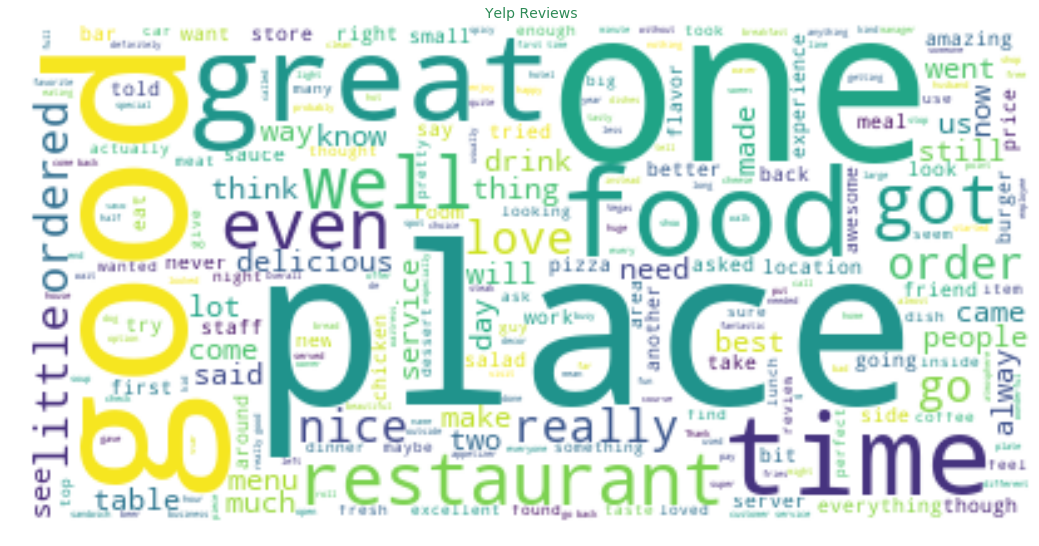

In [11]:
import imageio
import codecs
from wordcloud import WordCloud, STOPWORDS
f2 = open("mws.png", "wb")
f2.write(codecs.decode(alice_shelley,'base64'))
f2.close()
img2 = imageio.imread("mws.png")
alice_mask = img2

wc = WordCloud(background_color="white", max_words=5000, #mask=alice_mask,
               stopwords=STOPWORDS)
# generate word cloud
wc.generate(" ".join(texts[:10000]))

# show
plt.figure(figsize=(16,13))
plt.imshow(wc, interpolation='bilinear')
plt.title("Yelp Reviews", fontsize=14,color='seagreen')
plt.axis("off");


We can see most popular words users have written in review are food, good , great place, price , drink , delicious etc.
<a id='numerical'></a>


### Converting text into numerical representation i.e Tensors
Then we can format our text samples and labels into tensors that can be fed into a neural network. 
Some Preprocessing is needed here.
Tokenization - We need to break down the sentence into unique words. For eg, "The cow jumped over the moon" will become ["The","cow","jumped","over","moon"]

To do this, we will rely on Keras utilities keras.preprocessing.text.Tokenizer and keras.preprocessing.sequence.pad_sequences.



In [12]:

MAX_NUM_WORDS=1000 # how many unique words to use (i.e num rows in embedding vector)
MAX_SEQUENCE_LENGTH=100 # max number of words in a review to use


tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)


Found 155745 unique tokens.
Shape of data tensor: (265809, 100)
Shape of label tensor: (265809, 2)


<a id='split'></a>

###  split the data into a training set and a validation set

In [13]:
VALIDATION_SPLIT=0.2

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

<a id='embedding_layer'></a>

### Preparing the Embedding layer

In [14]:
GLOVE_DIR='/home/ashish/test/glove.6B/'

import os
embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


<a id='embedding_matrix'></a>


### compute  embedding matrix
At this point we can leverage our embedding_index dictionary and our word_index to compute our embedding matrix


In [15]:
EMBEDDING_DIM = 100 # how big is each word vector

embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

### Define Embedding Layer 
 We load this embedding matrix into an Embedding layer. Note that we set trainable=False to prevent the weights from being updated during training.


In [16]:
from keras.layers import Embedding

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)


### Training model :)

In [17]:
from keras.layers import Bidirectional, GlobalMaxPool1D,Conv1D
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation

from keras.models import Model


inp = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedded_sequences = embedding_layer(inp)
x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(2, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [18]:
model.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=3, batch_size=128);

Train on 212648 samples, validate on 53161 samples
Epoch 1/3
212648/212648 [==============================] - 566s 3ms/step - loss: 0.2502 - acc: 0.8939 - val_loss: 0.1784 - val_acc: 0.9264
Epoch 2/3
212648/212648 [==============================] - 559s 3ms/step - loss: 0.1772 - acc: 0.9287 - val_loss: 0.1592 - val_acc: 0.9364
Epoch 3/3
212648/212648 [==============================] - 810s 4ms/step - loss: 0.1581 - acc: 0.9370 - val_loss: 0.1452 - val_acc: 0.9419


### Spacy

spaCy is an industrial-strength natural language processing (NLP) library for Python. spaCy's goal is to take recent advancements in natural language processing out of research papers and put them in the hands of users to build production software.

spaCy handles many tasks commonly associated with building an end-to-end natural language processing pipeline:

1. Tokenization
2. Text normalization, such as lowercasing, stemming/lemmatization
3. Part-of-speech tagging
4. Syntactic dependency parsing
5. Sentence boundary detection
6. Named entity recognition and annotation

Let's take a sample review

In [1]:
import spacy
nlp = spacy.load('en')
sample_review=reviews.text[5]
sample_review


OSError: [E050] Can't find model 'en'. It doesn't seem to be a shortcut link, a Python package or a valid path to a data directory.

In [ ]:
%%time
parsed_review = nlp(sample_review)
print(parsed_review)

looks like nothing changed. 
Let's check againn.
### Sentence detection and segmentation



In [ ]:
for num, sentence in enumerate(parsed_review.sents):
    print ('Sentence {}:'.format(num + 1))
    print (sentence)
    print ('\n')

### Named entity detection

In [ ]:
for num, entity in enumerate(parsed_review.ents):
    print ('Entity {}:'.format(num + 1), entity, '-', entity.label_)
    print ('\n')

### Part of speech tagging

In [ ]:
token_text = [token.orth_ for token in parsed_review]
token_pos = [token.pos_ for token in parsed_review]

parts_of_speech=pd.DataFrame(data=list(zip(token_text, token_pos)),columns=['token_text', 'part_of_speech'])
parts_of_speech.head(10)

### Text normalization, like stemming/lemmatization and shape analysis

The work at this stage attempts to reduce as many different variations of similar words into a single term ( different branches all reduced to single word stem). Therefore if we have "running", "runs" and "run", you would really want these three distinct words to collapse into just the word "run". (However of course you lose granularity of the past, present or future tense).



In [ ]:
token_lemma = [token.lemma_ for token in parsed_review]
token_shape = [token.shape_ for token in parsed_review]

text_normalized_DF=pd.DataFrame(list(zip(token_text, token_lemma, token_shape)),
             columns=['token_text', 'token_lemma', 'token_shape'])
text_normalized_DF.head()

### Token-level entity analysis


In [ ]:
token_entity_type = [token.ent_type_ for token in parsed_review]
token_entity_iob = [token.ent_iob_ for token in parsed_review]

entity_analysis=pd.DataFrame(list(zip(token_text, token_entity_type, token_entity_iob)),
             columns=['token_text', 'entity_type', 'inside_outside_begin'])
entity_analysis.head()

### Token  attributes

such as the relative frequency of tokens, and whether or not a token matches any of these categories

stopword
punctuation
whitespace
represents a number
whether or not the token is included in spaCy's default vocabulary?

In [ ]:
token_attributes = [(token.orth_,
                     token.prob,
                     token.is_stop,
                     token.is_punct,
                     token.is_space,
                     token.like_num,
                     token.is_oov)
                    for token in parsed_review]

token_attributes = pd.DataFrame(token_attributes,
                  columns=['text',
                           'log_probability',
                           'stop?',
                           'punctuation?',
                           'whitespace?',
                           'number?',
                           'out of vocab.?'])

token_attributes.loc[:, 'stop?':'out of vocab.?'] = (token_attributes.loc[:, 'stop?':'out of vocab.?']
                                       .applymap(lambda x: u'Yes' if x else u''))
                                               
token_attributes.head()